# 0. 분석모듈 불러오기

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. 월단위 발전량 예측모델링

### 1-1. 월단위 발전량 데이터 불러오기 및 확인

In [2]:
data_monthly = pd.read_csv('DaeYeon_Monthly.csv')

In [3]:
data_monthly.head()

date      power
0  Jan-16   14036.80
1  Feb-16   66400.94
2  Mar-16   95319.88
3  Apr-16   85375.07
4  May-16  101193.62

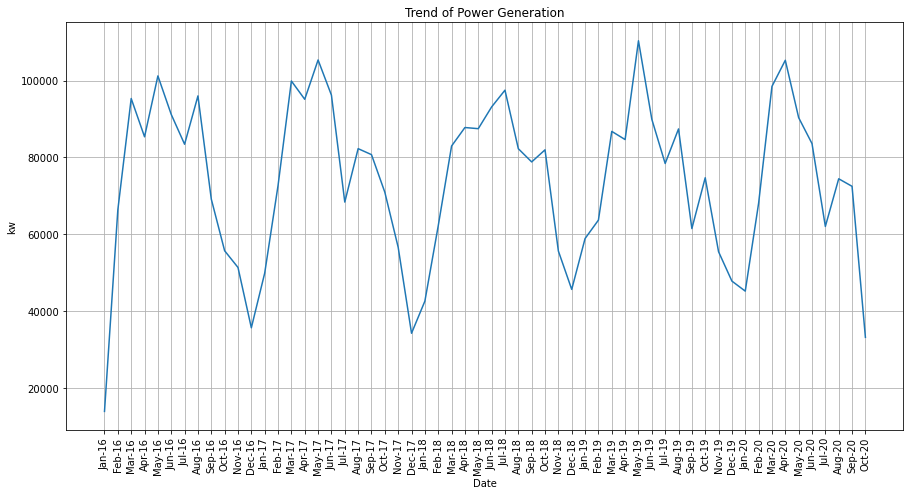

In [4]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data_monthly['date'], data_monthly['power'])
plt.title('Trend of Power Generation')
plt.ylabel('kw')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### 1-2. 모델 적용 시차 식별(ACF, PACF)

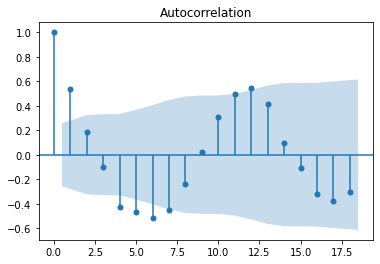

In [5]:
plot_pacf(data_monthly['power']);
plot_acf(data_monthly['power']);

### 1-3. 추세여부(정상성) 검정: ADF 검정

In [6]:
ad_fuller_result = adfuller(data_monthly['power'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.635507338577689
p-value: 5.57589376771345e-09


### 1-4. 모델링 함수 설정

In [7]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

### 1-5. 모델 시차 적용: SARIMA(p,d,q)(P,D,Q)12

In [8]:
best_model = SARIMAX(data_monthly['power'], order=(1, 0, 1), seasonal_order=(0, 1, 1, 12)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              power   No. Observations:                   58
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -498.229
Date:                            Fri, 13 Nov 2020   AIC                           1004.458
Time:                                    12:54:20   BIC                           1011.773
Sample:                                         0   HQIC                          1007.198
                                             - 58                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9659      0.036     27.037      0.000       0.896       1.036
ma.L1         -0.7939      0.134   

### 1-6 잔차 확인: 모델 수정여부 탐색

In [9]:
best_model.plot_diagnostics(figsize=(15,12));

### 1-7. 발전량 실제치-예측치 도표 확인
##### 8개월 이후 예측 도표 추가

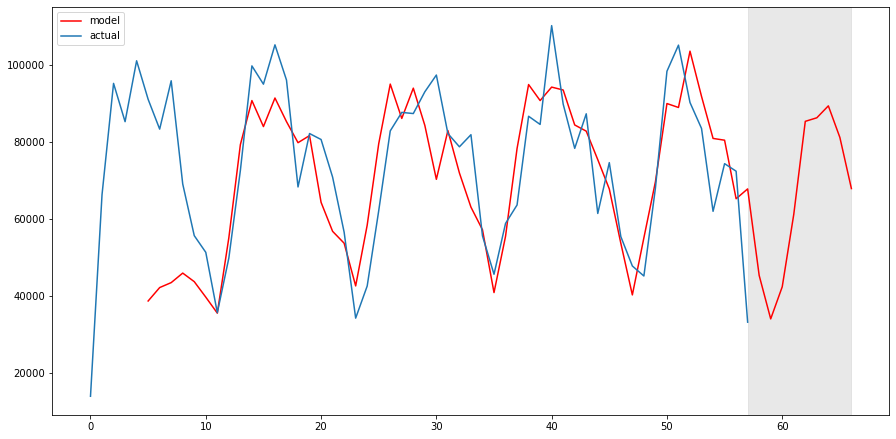

In [10]:
data_monthly['arima_model'] = best_model.fittedvalues
data_monthly['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=data_monthly.shape[0], end=data_monthly.shape[0] + 8)
forecast = data_monthly['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data_monthly.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data_monthly['power'], label='actual')
plt.legend()
plt.show()

#### 4개월 이후 발전량 예측치 계산 및 출력

In [11]:
forecast = best_model.predict(start=data_monthly.shape[0], end=data_monthly.shape[0] + 4)

In [12]:
forecast

58    45428.689105
59    34137.492164
60    42476.255946
61    61280.145980
62    85461.153717
Name: predicted_mean, dtype: float64